# Diffusion Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils

import os
import matplotlib.pyplot as plt
import numpy as np
import imageio
import copy
import math

from tqdm import trange, tqdm

!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

In [2]:
# training parameters
batch_size = 128
lr = 1e-4
train_epoch = 2 # To see the process works fine without any interuption

# data_loader
img_size = 32

data_set_root = "../../datasets"

In [3]:
# Use a GPU if avaliable
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

## Loading Dataset

In this section we are defining what augmention to apply to the FashionMNIST dataset.
- rotating images
- moving images
- scaling images
- flipping images

In [4]:
transform = transforms.Compose([
    # Resize the PIL image to 32×32 so it fits the NN structure
    transforms.Resize((img_size, img_size)),

    # Augmentation (not a crazy one)
    transforms.RandomRotation(15),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.RandomHorizontalFlip(p=0.5),

    # Moving to Tensor
    transforms.ToTensor(),

    # Applying RandomErasing
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1)),

    # Normalisation
    transforms.Normalize((0.5,), (0.5,)),
])

trainset = datasets.FashionMNIST(data_set_root, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

100%|██████████| 26421880/26421880 [00:01<00:00, 13910364.38it/s]


Extracting ../../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209321.59it/s]


Extracting ../../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3912743.39it/s]


Extracting ../../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26077629.22it/s]

Extracting ../../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../datasets/FashionMNIST/raw



## Model Definition

In [5]:
class ConditionalNorm2d(nn.Module):
    def __init__(self, channels, num_features, norm_type="gn"):
        super(ConditionalNorm2d, self).__init__()
        self.channels = channels
        if norm_type == "bn":
            self.norm = nn.BatchNorm2d(channels, affine=False, eps=1e-4)
        elif norm_type == "gn":
            self.norm = nn.GroupNorm(8, channels, affine=False, eps=1e-4)
        else:
            raise ValueError("Normalisation type not recognised.")

        self.fcw = nn.Linear(num_features, channels)
        self.fcb = nn.Linear(num_features, channels)

    def forward(self, x, features):
        out = self.norm(x)
        w = self.fcw(features)
        b = self.fcb(features)

        out = w.view(-1, self.channels, 1, 1) * out + b.view(-1, self.channels, 1, 1)
        return out


class ResDown(nn.Module):
    """
    Residual down sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=128):
        super(ResDown, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)
        self.conv1 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_out, num_features=num_features)
        self.conv2 = nn.Conv2d(channel_out, channel_out, kernel_size, 1, kernel_size // 2)
        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)
        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.act_fnc(self.norm1(x, features))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResUp(nn.Module):
    """
    Residual up sampling block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2, num_features=128):
        super(ResUp, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)
        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)
        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")
        self.act_fnc = nn.ELU()

    def forward(self, x, features):
        x = self.up_nn(self.act_fnc(self.norm1(x, features)))

        skip = self.conv3(x)

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class ResBlock(nn.Module):
    """
    Residual block
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, num_features=128):
        super(ResBlock, self).__init__()
        self.norm1 = ConditionalNorm2d(channel_in, num_features=num_features)
        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, 1, kernel_size // 2)
        self.norm2 = ConditionalNorm2d(channel_in, num_features=num_features)
        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        if not channel_in == channel_out:
            self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        else:
            self.conv3 = None

        self.act_fnc = nn.ELU()

    def forward(self, x_in, features):
        x = self.act_fnc(self.norm1(x_in, features))

        if self.conv3 is not None:
            skip = self.conv3(x)
        else:
            skip = x_in

        x = self.act_fnc(self.norm2(self.conv1(x), features))
        x = self.conv2(x)

        return x + skip


class Encoder(nn.Module):
    """
    Encoder block
    """

    def __init__(self, channels, ch=64, blocks=(1, 2, 4), num_features=128):
        super(Encoder, self).__init__()
        self.conv_in = nn.Conv2d(channels, blocks[0] * ch, 3, 1, 1)

        widths_in = list(blocks)
        widths_out = list(blocks[1:]) + [blocks[-1]]

        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResDown(w_in * ch, w_out * ch, num_features=num_features))

        self.block_out = ResBlock(w_out * ch, w_out * ch, num_features=num_features)
        self.act_fnc = nn.ELU()

    def forward(self, x, index_features):
        x = self.conv_in(x)
        skip_list = [x]

        for block in self.layer_blocks:
            x = block(x, index_features)
            skip_list.append(x)

        x = self.block_out(x, index_features)
        return x, skip_list


class Decoder(nn.Module):
    """
    Decoder block
    Built to be a mirror of the encoder block
    """

    def __init__(self, channels, ch=64, blocks=(1, 2, 4), num_features=128):
        super(Decoder, self).__init__()

        widths_out = list(blocks)[::-1]
        widths_in = (list(blocks[1:]) + [blocks[-1]])[::-1]

        self.block_in = ResBlock(blocks[-1] * ch, blocks[-1] * ch, num_features=num_features)
        self.layer_blocks = nn.ModuleList([])

        for w_in, w_out in zip(widths_in, widths_out):
            self.layer_blocks.append(ResUp(w_in * ch * 2, w_out * ch, num_features=num_features))

        self.conv_out = nn.Conv2d(blocks[0] * ch * 2, channels, 3, 1, 1)
        self.act_fnc = nn.ELU()

    def forward(self, x_in, skip_list, index_features):
        x = self.block_in(x_in, index_features)

        for block in self.layer_blocks:
            skip = skip_list.pop()
            x = torch.cat((x, skip), 1)
            x = block(x, index_features)

        skip = skip_list.pop()
        x = torch.cat((x, skip), 1)
        return self.conv_out(x)


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Unet(nn.Module):
    """
    Unet network, uses the above encoder and decoder blocks
    """
    def __init__(self, channel_in=3, ch=32, blocks=(1, 2, 4), timesteps=20, num_features=128):
        super(Unet, self).__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(num_features),
            nn.Linear(num_features, 2 * num_features),
            nn.GELU(),
            nn.Linear(2 * num_features, num_features),
            nn.GELU()
        )

        self.encoder = Encoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)
        self.decoder = Decoder(channel_in, ch=ch, blocks=blocks, num_features=num_features)

    def forward(self, x, index):
        index_features = self.time_mlp(index)

        bottleneck, skip_list = self.encoder(x, index_features)
        recon_img = self.decoder(bottleneck, skip_list, index_features)
        return recon_img

## Cosine schedual

We are using Cosine schedule for adding noise to the images. After trying the linear schedule on a different dataset (pixel-art sprites dataset), we concluded that it is not helping the model to learn features very well.



In [6]:
def cosine_alphas_bar(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, steps, steps)
    alphas_bar = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    return alphas_bar[:timesteps]

## Reverse Cold Diffusion Process
We're implementing DDIM, specifically cold diffusion, which can use any transformation, however we are just doing de-noising.

In [7]:
def noise_from_x0(curr_img, img_pred, alpha):
    return (curr_img - alpha.sqrt() * img_pred)/((1 - alpha).sqrt() + 1e-4)

In [8]:
def cold_diffuse(diffusion_model, sample_in, total_steps):
    diffusion_model.eval()
    bs = sample_in.shape[0]
    alphas = torch.flip(cosine_alphas_bar(total_steps), (0,)).to(device)
    random_sample = copy.deepcopy(sample_in)
    with torch.no_grad():
        for i in trange(total_steps - 1):
            index = (i * torch.ones(bs, device=sample_in.device)).long()

            img_output = diffusion_model(random_sample, index)

            noise = noise_from_x0(random_sample, img_output, alphas[i])
            x0 = img_output

            rep1 = alphas[i].sqrt() * x0 + (1 - alphas[i]).sqrt() * noise
            rep2 = alphas[i + 1].sqrt() * x0 + (1 - alphas[i + 1]).sqrt() * noise

            random_sample += rep2 - rep1

        index = ((total_steps - 1) * torch.ones(bs, device=sample_in.device)).long()
        img_output = diffusion_model(random_sample, index)

    return img_output

In [9]:
# Create a dataloader itterable object
dataiter = iter(train_loader)
# Sample from the itterable object
images, labels = next(dataiter)

In [10]:
timesteps = 50

# network
u_net = Unet(channel_in=images.shape[1], ch=32, blocks=(1, 2, 4), timesteps=timesteps).to(device)

#A fixed latent noise vector so we can see the improvement over the epochs
fixed_latent_noise = torch.randn(images.shape[0], images.shape[1], img_size, img_size).to(device)

# Adam optimizer
optimizer = optim.Adam(u_net.parameters(), lr=lr)
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epoch, eta_min=0)

In [11]:
loss_log = []
mean_loss = 0

alphas = torch.flip(cosine_alphas_bar(timesteps), (0,)).to(device)

In [ ]:
_ = plt.plot(alphas.cpu())

In [13]:
alpha_batch = alphas.reshape(-1, 1, 1, 1)
images_1 = images[0:1].expand(alpha_batch.shape[0], images.shape[1], img_size, img_size).to(device)
latent_noise = torch.randn_like(images_1)
noise_input = alpha_batch.sqrt() * images_1 + (1 - alpha_batch).sqrt() * latent_noise

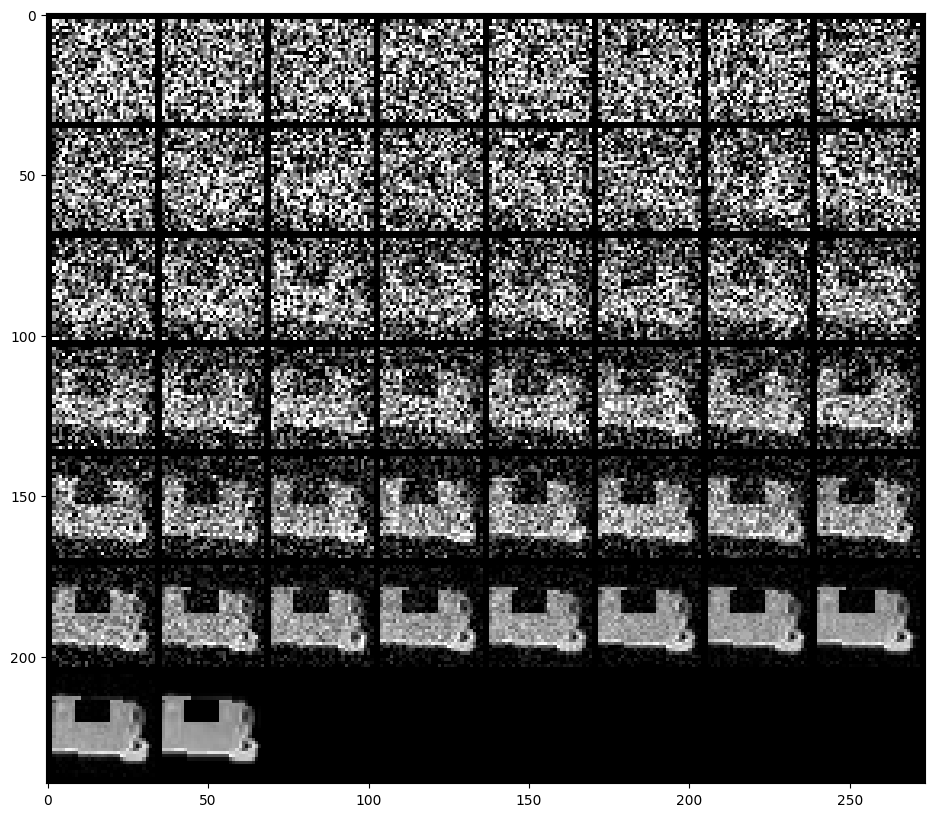

In [14]:
# Lets visualise an entire batch of images!
# As you can see, starting from noisy image to denoised image (it's a process)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(torch.clamp(noise_input, -1, 1).cpu(), 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [15]:
bs = images.shape[0]
images = images.to(device)

rand_index = torch.randint(timesteps, (bs, ), device=device)
alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)
noise_input = alpha_batch.sqrt() * images + (1 - alpha_batch).sqrt() * fixed_latent_noise

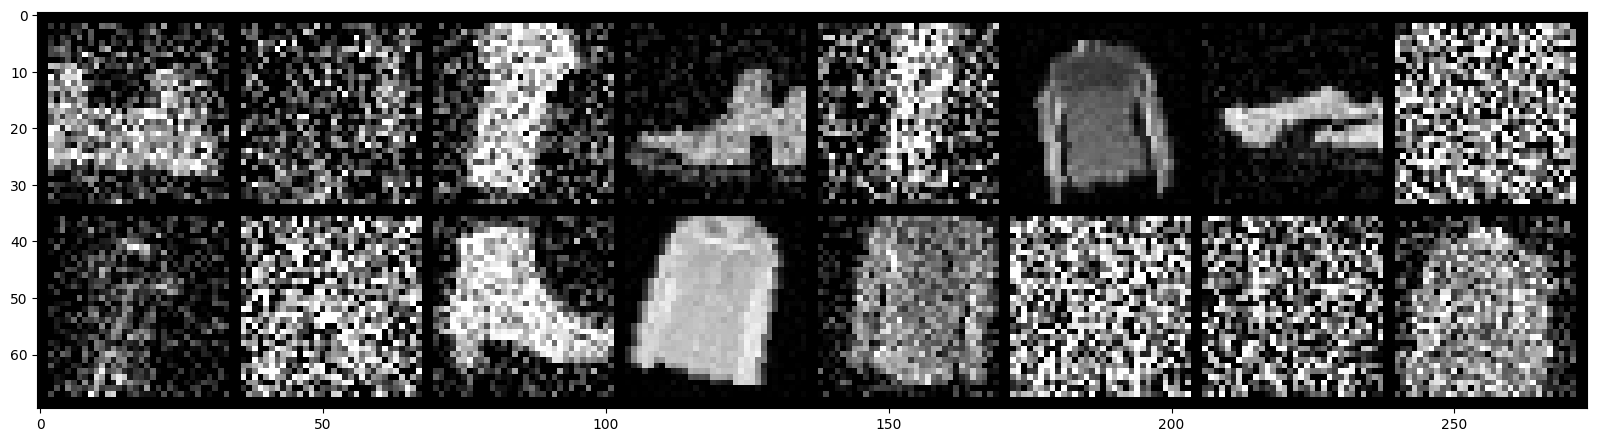

In [16]:
# Visualising noisy images.
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(torch.clamp(noise_input, -1, 1)[:16].cpu(), 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

# This is a new trial!!!

After trying to run the code multiple times, we realised that we should be saving outputs and models at each epoch. This will help us access the images, models, and in case of timeout error (training stops all of a sudden) we have access to those saved models to continue working on the project. 

In [ ]:
from torchvision.utils import save_image

train_epoch = 80

"""
Considering to remove this function from the loop as we can
later access the saved model to generate 1000 images for the targeted epochs. 
(say epoch 1, 10, 20, 30, 40, 50)
This way we can save memory and hopefully reduce training time.
"""

def save_individual_samples(model, epoch, out_dir="fid_images", num_images=1000, image_size=64, device='cuda'):
    model.eval()
    sample_dir = os.path.join(out_dir, f"epoch_{epoch}_samples")
    os.makedirs(sample_dir, exist_ok=True)

    with torch.no_grad():
        for i in range(num_images):
            z = torch.randn(1, 1, image_size, image_size).to(device)  # grayscale
            generated = cold_diffuse(model, z, total_steps=timesteps)
            generated = (generated + 1) / 2  # scale to [0, 1]

            # Convert to 3-channel if needed for FID/PNG
            generated = generated.repeat(1, 3, 1, 1)

            save_image(generated, os.path.join(sample_dir, f"image_{i:03d}.png"))

import os

# Directory to save model checkpoints and images
save_dir = "training_output"
os.makedirs(save_dir, exist_ok=True)

pbar = trange(train_epoch, leave=False, desc="Epoch")
u_net.train()
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (mean_loss/len(train_loader)))
    mean_loss = 0

    for num_iter, (images, labels) in enumerate(tqdm(train_loader, leave=False)):

        images = images.to(device)

        #the size of the current minibatch
        bs = images.shape[0]

        rand_index = torch.randint(timesteps, (bs, ), device=device)
        random_sample = torch.randn_like(images)
        alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)

        noise_input = alpha_batch.sqrt() * images + (1 - alpha_batch).sqrt() * random_sample

        img_pred = u_net(noise_input, rand_index)

        loss = F.l1_loss(img_pred, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #log the generator training loss
        loss_log.append(loss.item())
        mean_loss += loss.item()

    # Save model checkpoint
    model_path = os.path.join(save_dir, f"model_epoch_{epoch}.pth")
    torch.save(u_net.state_dict(), model_path)
    
    fake_sample = cold_diffuse(u_net, fixed_latent_noise, total_steps=timesteps)
    grid = vutils.make_grid(fake_sample.detach().cpu(), nrow=16, normalize=True)
    torchvision.utils.save_image(grid, os.path.join(save_dir, f"image_epoch_{epoch}.png"))

    lr_schedule.step()


100%|██████████| 469/469 [00:29<00:00, 16.69it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.52it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.67it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.62it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.64it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.74it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.55it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.47it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.61it/s]
                                                 
100%|██████████| 469/469 [00:29<00:00, 16.59it/s]
                                                 


In [30]:
def generate_samples_from_checkpoints(
    model, 
    checkpoint_dir="training_output", 
    output_dir="fid_images", 
    epochs=[0, 10, 20, 30, 40, 50, 60, 70, 79], 
    # epochs = [0,1],
    num_images=1000, 
    device='cuda'
):
    model.eval()
    for epoch in epochs:
        print(f"Generating samples for epoch {epoch}...")
        ckpt_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        save_individual_samples(model, epoch, out_dir=output_dir, num_images=num_images, image_size=64, device=device)


generate_samples_from_checkpoints(u_net, device=device)

Generating samples for epoch 0...


100%|██████████| 49/49 [00:00<00:00, 176.32it/s]


Generating samples for epoch 10...


100%|██████████| 49/49 [00:00<00:00, 174.17it/s]


Generating samples for epoch 20...


100%|██████████| 49/49 [00:00<00:00, 174.73it/s]


Generating samples for epoch 30...


100%|██████████| 49/49 [00:00<00:00, 164.20it/s]


Generating samples for epoch 40...


100%|██████████| 49/49 [00:00<00:00, 181.05it/s]


Generating samples for epoch 50...


100%|██████████| 49/49 [00:00<00:00, 177.86it/s]


Generating samples for epoch 60...


100%|██████████| 49/49 [00:00<00:00, 178.77it/s]


Generating samples for epoch 70...


100%|██████████| 49/49 [00:00<00:00, 178.68it/s]


Generating samples for epoch 79...


100%|██████████| 49/49 [00:00<00:00, 182.99it/s]


In [28]:
from PIL import Image
import os

# Directory with timelapse images
img_dir = "training_output"

# Sort images by epoch number
img_paths = sorted(
    [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.startswith("image_epoch_")],
    key=lambda x: int(x.split("_")[-1].split(".")[0])
)

# Load images
images = [Image.open(img_path).convert("RGB") for img_path in img_paths]

# Save as animated GIF
output_gif = os.path.join(img_dir, "diffusion_timelapse.gif")
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=100,  # ms per frame
    loop=1
)

print(f"Saved GIF to: {output_gif}")

Saved GIF to: training_output/diffusion_timelapse.gif


In [29]:
from IPython.display import FileLink
FileLink(r'training_output/diffusion_timelapse.gif')

/kaggle/working/training_output/diffusion_timelapse.gif

In [ ]:
import shutil
shutil.rmtree("fid_images/epoch_0_samples", ignore_errors=True)

# Regenerate 1000 samples
save_individual_samples(
    model=u_net,
    epoch=0,
    out_dir="fid_images",
    num_images=1000,
    image_size=64,
    device=device
)

In [ ]:
import shutil
shutil.rmtree("fid_images/epoch_49_samples", ignore_errors=True)

# Regenerate 1000 samples
save_individual_samples(
    model=u_net,
    epoch=49,
    out_dir="fid_images",
    num_images=1000,
    image_size=64,
    device=device
)

 82%|████████▏ | 40/49 [00:00<00:00, 189.91it/s]

In [38]:
import torch_fidelity.metric_fid as fid_mod
import numpy as np
from scipy.linalg import sqrtm 

def safe_fid_statistics_to_metric(stat_1, stat_2, verbose=False):
    mu1, sigma1 = stat_1['mu'], stat_1['sigma']
    mu2, sigma2 = stat_2['mu'], stat_2['sigma']

    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)

    if not np.isfinite(covmean).all():
        covmean = np.nan_to_num(covmean)

    covmean = covmean.real  # force drop imaginary part

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return {'frechet_inception_distance': float(fid)}

fid_mod.fid_statistics_to_metric = safe_fid_statistics_to_metric

In [63]:
fid = torch_fidelity.calculate_metrics(
    input1='fid_images/epoch_0_samples',
    input2='fid_images/epoch_79_samples',
    fid=True,
    cuda=torch.cuda.is_available()
)
print(f"FID at epoch 79: {fid['frechet_inception_distance']:.2f}")

Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "fid_images/epoch_0_samples" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples                                                          
Extracting statistics from input 2
Looking for samples non-recursivelty in "fid_images/epoch_79_samples" with extensions png,jpg,jpeg
Found 1000 samples
Processing samples                                                          


FID at epoch 79: 147119571923125330402401314606429681627398955729625808896.00


100%|██████████| 80/80 [00:03<00:00, 21.07it/s]


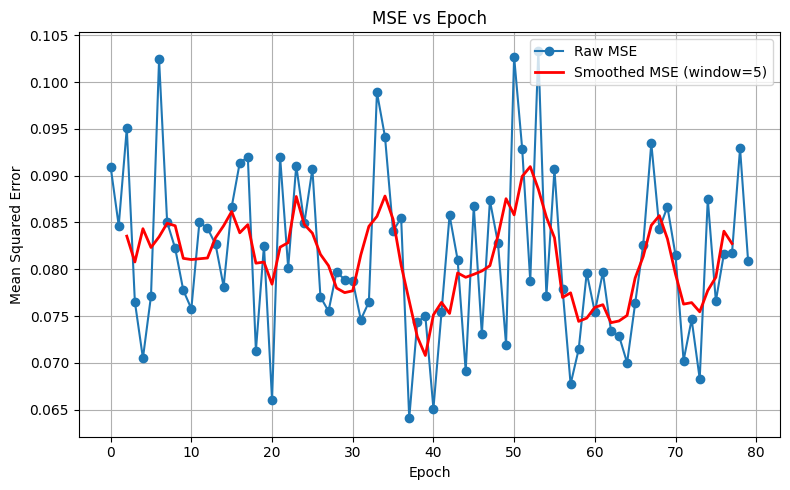

In [78]:
val_iter = iter(train_loader)
images, _ = next(val_iter)
images = images[:1000].to(device)

mse_scores = []

def compute_mse(model, images, alphas, timesteps, device):
    model.eval()
    bs = images.shape[0]
    
    rand_index = torch.randint(0, timesteps, (bs,), device=device)
    noise = torch.randn_like(images)
    alpha = alphas[rand_index].reshape(bs, 1, 1, 1)
    
    noisy_input = alpha.sqrt() * images + (1 - alpha).sqrt() * noise
    with torch.no_grad():
        pred = model(noisy_input, rand_index)
    mse = F.mse_loss(pred, images).item()
    return mse

for epoch in tqdm(range(0, 80)):
    ckpt_path = f"training_output/model_epoch_{epoch}.pth"
    u_net.load_state_dict(torch.load(ckpt_path, map_location=device))
    mse = compute_mse(u_net, images, alphas, timesteps, device)
    mse_scores.append(mse)


import matplotlib.pyplot as plt
import numpy as np

# Compute a simple moving average for smoothing
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_mse = moving_average(mse_scores, window_size=5)
smoothed_epochs = range(2, 78)  # Adjust to match smoothed values (centered)

plt.figure(figsize=(8, 5))
plt.plot(range(0, 80), mse_scores, marker='o', linestyle='-', label='Raw MSE')
plt.plot(smoothed_epochs, smoothed_mse, color='red', linewidth=2, label='Smoothed MSE (window=5)')
plt.title("MSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("mse_vs_epoch_smoothed.png")
plt.show()

**COMMENT:**

**FID** calculated between 2 epochs (epoch 0 vs epoch 79) is astronomically high, which indicates that there must be an issue with the images used. Having checked the outcome in the below cell, we conclude that the issue is due to images mostly being black and cannot calculate FID well.

Instead we visualise the sample images and epoch79 images to showcase how well the model leant to denoise the images. (find in **Analysis and Visualization** section for them.)

When we look at the **MSE vs Epoch** plot, 30-50 epochs would be the best idea for training. We can see slight negative trend upto about 45, then it starts going up slightly. This might look different if I use more complicated model.

In [66]:
from torchvision.io import read_image
import os

folder = 'fid_images/epoch_79_samples'
samples = os.listdir(folder)[:10]

for fname in samples:
    img = read_image(os.path.join(folder, fname)).float() / 255.
    print(fname, f"min={img.min():.3f}", f"max={img.max():.3f}", f"mean={img.mean():.3f}")

image_135.png min=0.000 max=1.000 mean=0.179
image_593.png min=0.000 max=1.000 mean=0.326
image_416.png min=0.000 max=1.000 mean=0.318
image_590.png min=0.000 max=1.000 mean=0.167
image_250.png min=0.000 max=1.000 mean=0.517
image_933.png min=0.000 max=1.000 mean=0.190
image_992.png min=0.000 max=1.000 mean=0.191
image_844.png min=0.000 max=1.000 mean=0.080
image_349.png min=0.000 max=1.000 mean=0.226
image_493.png min=0.000 max=1.000 mean=0.525


# Analysis and Visualization

We can see that the denoising is working just fine -we could call this average. Moreover, the model seems to pick features as we can see smooth structures in many images, however it seems to denoise and generate average shape such as shirt or something close to shirt or mixture of all items (blob). Meaning that there is an opportunity to finetune the model to further denoise the sample images.

From the logloss plot, there is a huge drop in range step 0-1000. The loss starts very high, which is expected at the beginning of the training, then dropping rapidly. This indicates that the model is learning the denoising pattern. Then we see the loss becoming stable after 1000 steps at around 0.15.



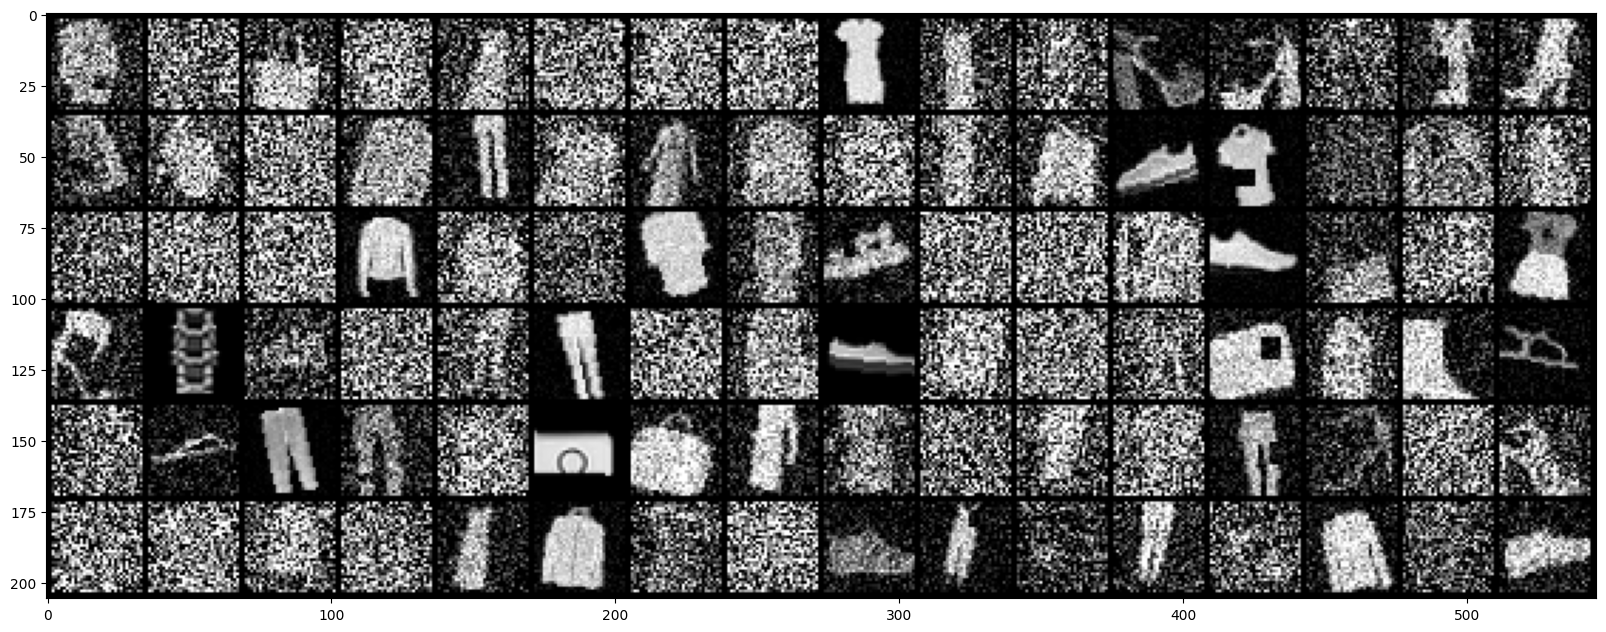

In [58]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(torch.clamp(noise_input, -1, 1).detach().cpu(), nrow=16, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

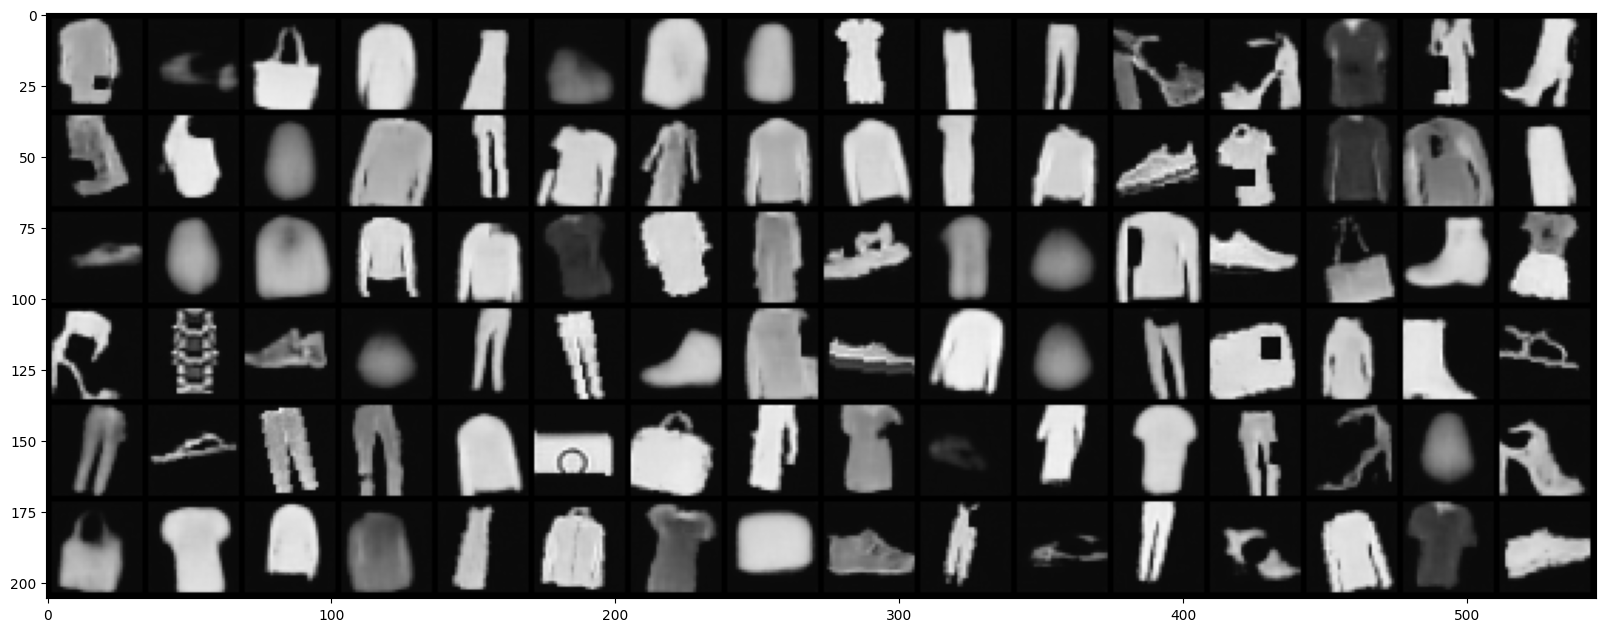

In [59]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(img_pred.detach().cpu(), nrow=16, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

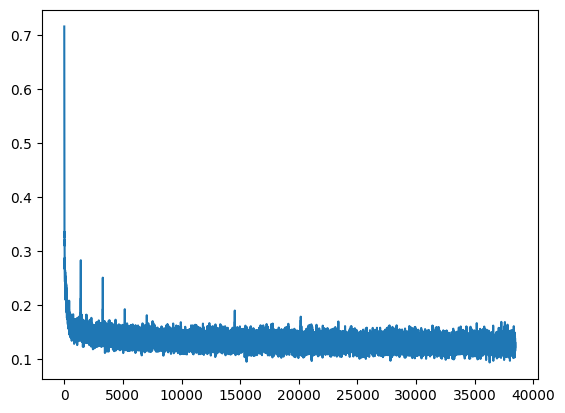

In [49]:
plt.plot(loss_log)

In [50]:
fake_sample = cold_diffuse(u_net, fixed_latent_noise, total_steps=timesteps)

100%|██████████| 49/49 [00:00<00:00, 54.87it/s]


## Summary Report

### Model:
As an extension of work I found on [GitHub](https://github.com/LukeDitria/pytorch_tutorials/blob/main/section09_generation/solutions/Pytorch2_Diffusion.ipynb), a simplified U-Net-based **DDIM (Denoising Diffusion Implicit Model)** was implemented for this project. I added features like data augmentation, evaluation metrics, and model checkpoint saving. The model uses **deterministic cold-start sampling** through reverse denoising steps, avoiding the randomness of DDPM. A **cosine noise schedule** was chosen over a linear one because it gradually adds noise, helping the model learn features more effectively in the early stages.

### Dataset:
The model was trained on the **FashionMNIST** dataset, just like in the original GitHub code. Images were **resized to 32×32 pixels**, augmented with **random rotation, scaling, and horizontal flipping**, and normalized to the range `[-1, 1]` to boost data variety and improve generalization.

### Loss Function:
I used **L1 loss** for training, which encourages accurate pixel-level reconstruction.

### Training Process:
- The model was trained for **80 epochs**, saving both checkpoints and sample outputs at each epoch.
- Training loss dropped quickly early on and stabilized around **0.13**, showing decent convergence.
- A **fixed evaluation batch** was used to calculate **MSE per epoch**, which stayed fairly consistent with minor fluctuations.

### Sampling and Evaluation:
- **Grid images** of generated samples were saved every epoch to track progress visually.
- A **timelapse animation** was created to show how the model improved over time.
- **FID (Fréchet Inception Distance)** was used to evaluate output quality. However, outputs in the later epochs had low contrast and diversity, which caused FID to spike.
- I tried fixing this with **contrast normalization** and sample filtering, but FID still stayed high due to degraded image quality.

### Visualizations:
- Image grids clearly showed improvement early in training, then stagnation in later epochs.
- A **training loss curve** was plotted to show how loss changed over time.
- The **MSE vs. Epoch** plot included a **red smoothed line** to highlight denoising stability throughout training.

### Limitations:
- **Mode collapse** happened in the later epochs, reducing sample variety and leading to inflated FID scores.
- FID became **unstable** when evaluating collapsed or low-variance outputs.

### Future Work:
- We can test the model on **larger and more complex datasets** like **CIFAR-10**, **CelebA**, or **FFHQ** to better assess generalization and performance.
